In [ ]:
!pip install sbi

# Part 1: The Lotka-volterra simulator

In this tutorial, we will perform Simulation-based inference on the Lotka-Volterra simulator.  

The Lotka-Volterra simulator models the population of prey and predator, given four parameters:

- $\alpha$: Prey birth rate: The rate at which prey reproduce in the absence of predators
- $\beta$: Predation rate: The rate at which predators consume prey, reducing the prey population
- $\delta$: Predator reproduction rate: The rate at which predators reproduce based on prey consumption
- $\gamma$: Predator death rate: The rate at which predators die in the absence of prey

In [104]:
import numpy as np

_ = np.random.seed(0)

def lotka_volterra(y, alpha, beta, delta, gamma):
    prey, predator = y
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return np.asarray([dprey_dt, dpredator_dt])

def simulate(parameters):
    alpha = parameters[0]
    beta = parameters[1]
    delta = parameters[2]
    gamma = parameters[3]

    y0 = np.asarray([40.0, 9.0])  # Initial populations
    t_span = 200  # Total simulation time
    dt = 0.1  # Time step

    timesteps = int(t_span / dt)
    y = np.zeros((timesteps, 2))
    y[0] = y0

    for i in range(1, timesteps):
        y[i] = y[i-1] + lotka_volterra(y[i-1], alpha, beta, delta, gamma) * dt

    return y

Let's inspect this simulator a set of example parameters:

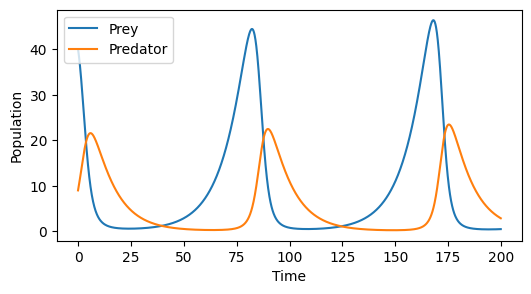

In [105]:
import matplotlib.pyplot as plt

time_vec = np.arange(0, 200, 0.1)

alpha = 0.1
beta = 0.02
delta = 0.01
gamma = 0.1

observation = simulate(np.asarray([alpha, beta, delta, gamma]))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(time_vec, observation)
_ = ax.legend(["Prey", "Predator"])
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Population")

> Task 1: Explore the simulator. Try running the simulator with different parameters. For example, decrease the birth rate of Prey $\alpha$ and see what happens.

To parallelize the simulation across many different parameter sets, you can (later on) use the following helper function:

In [106]:
from joblib import Parallel, delayed


def parallel_simulate(theta):
    """
    Args:
        theta: A batch of parameters of shape (N, 4).
    
    Returns:
        A batch of time series of shape (N, Time).
    """
    # Our simulator uses numpy, but prior samples are in PyTorch.
    theta_np = theta.numpy()

    num_workers = 8
    simulation_outputs = Parallel(n_jobs=num_workers)(
        delayed(simulate)(batch)
        for batch in theta_np
    )
    return np.asarray(simulation_outputs)

## Noise and summary statistics

Typically, we will not be able to observe populations exactly, but only with noise. In addition, in this example, we will aim to reproduce summary statistics of these simulations. Let's add noise and define these statistics:

In [107]:
def summarize_simulation(simulation_result):
    observation_noise = np.reshape(
        np.random.randn(2000 * 2),
        (2000, 2)
    )
    noisy_sim = simulation_result + observation_noise

    prey_population = noisy_sim[:, 0]
    predator_population = noisy_sim[:, 1]
    summary = [
        np.max(prey_population).item(),
        np.max(predator_population).item(),
        np.mean(prey_population).item(),
        np.mean(predator_population).item()
    ]
    return np.asarray(summary)

We can now compute the observation $x_o$ for which we will aim to obtain the posterior:

In [109]:
x_o = summarize_simulation(observation)
print(x_o.shape)

(4,)


To perform Bayesian inference, we also have to define a prior over the four parameters. In this case, we assume a uniform prior:

In [110]:
import torch

_ = torch.manual_seed(42)
from sbi.utils import BoxUniform

lower_bound = torch.as_tensor([0.05, 0.01, 0.005, 0.005])
upper_bound = torch.as_tensor([0.15, 0.03, 0.03, 0.15])
prior = BoxUniform(low=lower_bound, high=upper_bound)

# Part 2: Performing Approximate Bayesian Computation (ABC)

We now aim to use Approximate Bayesian Computation (ABC) to obtain approximate posterior samples.

First, we draw 1000 samples from the prior distribution.

In [117]:
N = 1000
theta = prior.sample((N,))

Next, for each parameter set, we run the simulation and compute the summary statistics.

In [118]:
simulation_outputs = parallel_simulate(theta)
x = np.asarray([summarize_simulation(sim) for sim in simulation_outputs])

We then visualize the simulation outputs.

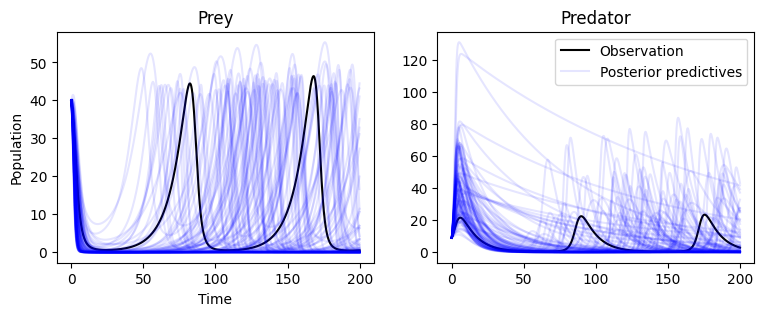

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
_ = ax[0].plot(time_vec, observation[:, 0], c="k")
_ = ax[0].plot(time_vec, simulation_outputs[::10, :, 0].T, alpha=0.1, c="b")
_ = ax[0].set_title("Prey")

_ = ax[1].plot(time_vec, observation[:, 1], c="k")
_ = ax[1].plot(time_vec, simulation_outputs[::10, :, 1].T, alpha=0.1, c="b")
_ = ax[1].set_title("Predator")

_ = ax[1].legend(["Observation", "Posterior predictives"])
_ = ax[0].set_xlabel("Time")
_ = ax[0].set_ylabel("Population")

As you can see, most simulation outputs (blue) are vastly different from the observation (black).

Next, for each simulation output $x$, we compute the Euclidean distance to the observation.

In [120]:
# `x_o`: Observation (shape (4,))
# `x`: Simulation outputs (shape (N, 4))
# `distance`: Euclidean distance between and x and x_o (shape (1000,))

distance = np.sum((x_o - x)**2, axis=1)

We then select every parameter set `theta` whose simulation output which has a distance closer than `epsilon=10.0`:

In [121]:
epsilon = 10.0
condition = distance < epsilon
theta_abc = theta[condition]

Next, we visualize the posterior distribution with the `pairplot` function.

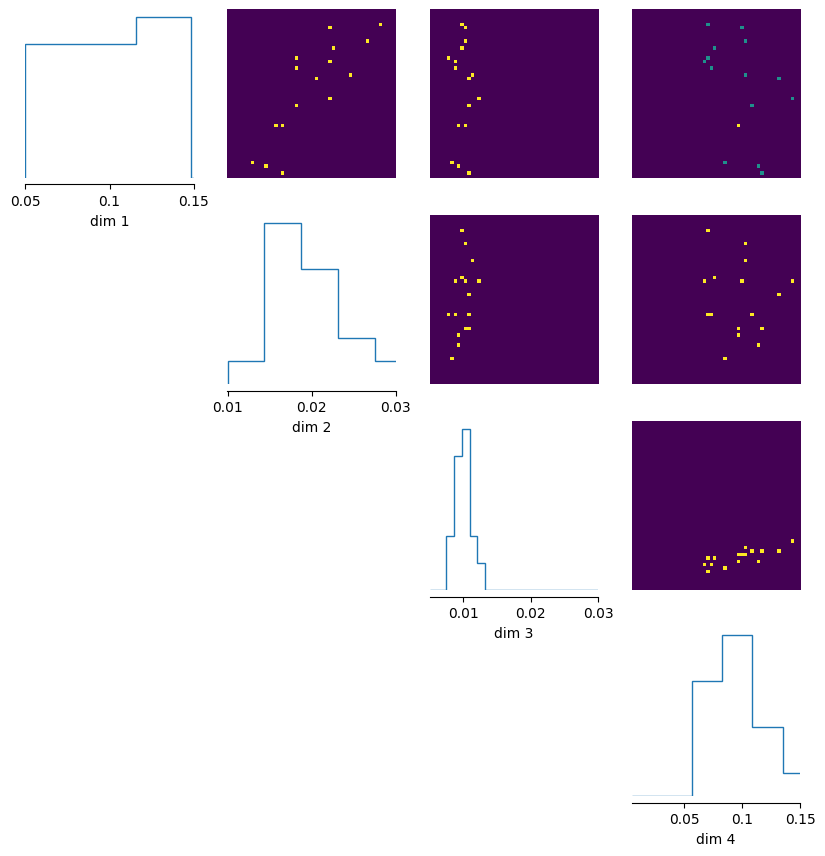

In [122]:
from sbi.analysis import pairplot

limits = torch.stack([lower_bound, upper_bound]).T
_ = pairplot(theta_abc, limits=limits)

The above `pairplot` shows the 1D marginals (on the diagonals) and the 2D marginals (upper diagonals) of the posterior distribution as histograms.

We then visualize **posterior predictive samples**, i.e. simulation outputs given approximate posterior samples:

In [123]:
posterior_predictives = parallel_simulate(theta_abc)

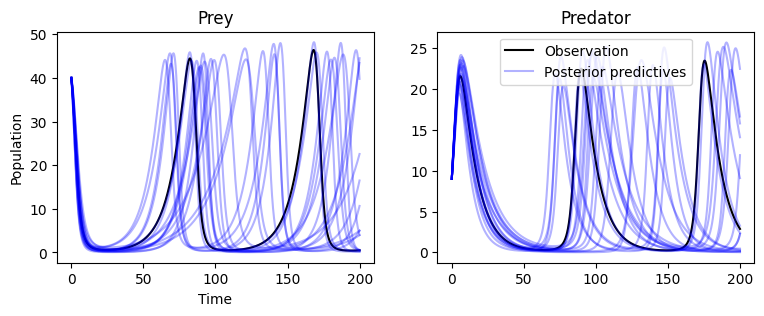

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
_ = ax[0].plot(time_vec, observation[:, 0], c="k")
_ = ax[0].plot(time_vec, posterior_predictives[:, :, 0].T, alpha=0.3, c="b")
_ = ax[0].set_title("Prey")

_ = ax[1].plot(time_vec, observation[:, 1], c="k")
_ = ax[1].plot(time_vec, posterior_predictives[:, :, 1].T, alpha=0.3, c="b")
_ = ax[1].set_title("Predator")

_ = ax[1].legend(["Observation", "Posterior predictives"])
_ = ax[0].set_xlabel("Time")
_ = ax[0].set_ylabel("Population")

As you can see, the simulation outputs are now closer to the observation.

You just performed Approximate Bayesian Computation (ABC). A core limitation of ABC is that it requires to tune a threshold `epsilon` (above: 10.0).

> Play around with different thresholds and see what happens. What problems does this cause?

# Part 3: Running Neural Posterior Estimation (NPE)

Neural Posterior Estimation (NPE) avoids having to define an `epsilon`. NPE trains a neural network to directly predict the posterior distribution for any `x_o`. Below, you will use the `sbi` toolbox to perform NPE.

## Generating training data

NPE begins just like ABC: by drawing samples from the prior and running the simulator.

Below, we generate 1000 prior samples, run the simulation, and compute summary statistics:

In [125]:
N = 1000
theta = prior.sample((N,))

simulation_outputs = parallel_simulate(theta)
x = np.asarray([summarize_simulation(sim) for sim in simulation_outputs])
x = torch.as_tensor(x, dtype=torch.float32)

## Setting up the neural network

For this example, we will use NPE with a neural spline flow (`nsf`) as density estimator. If you are interested, see [here](https://sbi.readthedocs.io/en/latest/sbi.html#neural-nets) for the collection of neural networks and [here](https://sbi.readthedocs.io/en/latest/how_to_guide/03_choose_neural_net.html) for a guide on which methods to choose.

In [126]:
from sbi.inference import NPE

inference = NPE(density_estimator="nsf")

We then train the network on our simulations:

In [127]:
posterior_net = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 161 epochs.

We can check the convergence of the training loop by inspecting its loss curve:

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/michaeldeistler/Documents/phd/talks/2509_ICANN_SBI_tutorial/sbi-logs/NPE_C/2025-09-08T12_32_58.430254' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


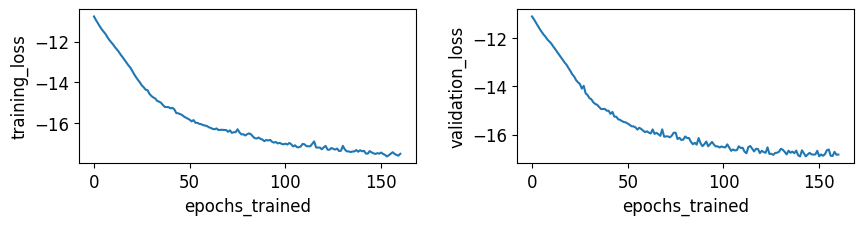

In [128]:
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)
# All training logs are available in `trainer.summary`.

In this case, the validation loss seems to still be going down, so it might be worth setting a higher value for `.train(stop_after_epochs=30)` (default value is 20). This parameter sets how many epochs must pass for without the validation loss reaching a new minimum. For this example, we will not retrain.

After training, we can build the `posterior`:

In [129]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Inferring the posterior

Let's aim to infer the posterior given our observation:

In [130]:
print("Observation: ", x_o)

Observation:  [47.56692179 25.25391609  9.46295055  6.04264831]


We draw samples from the NPE-posterior by drawing samples from the trained conditional generative model:

In [131]:
samples = posterior.sample((1_000,), x=x_o)

Drawing 1000 posterior samples for 1 observations: 100%|████████████| 1000/1000 [00:00<00:00, 37282.70it/s]


Note that you can infer the posterior distribution for any observation $x_{o}$ without having to run new simulations and without having to re-train. This property is called **amortization**.

## Visualizing the posterior

Next, we visualize these posterior samples with the `pairplot` function:

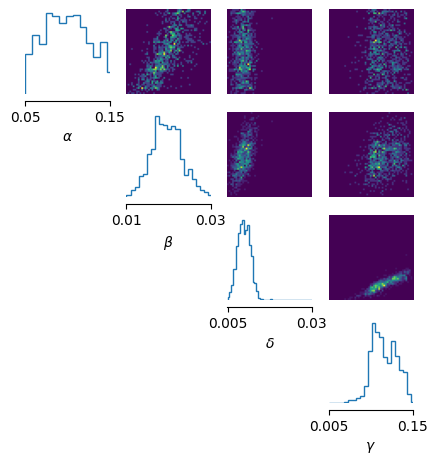

In [132]:
from sbi.analysis import pairplot

_ = pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    labels=[r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
)

To identify potential issues in the posterior estimate, we then perform **posterior predictive checks**. As above for ABC, simulate posterior samples and compare them to the observation:

In [133]:
posterior_samples = posterior.sample((10,), x=x_o)
posterior_predictives = parallel_simulate(posterior_samples)

posterior_predictive_summary_stats = torch.as_tensor(
    np.asarray([summarize_simulation(sim) for sim in simulation_outputs]),
    dtype=torch.float32
)

Drawing 10 posterior samples for 1 observations: 100%|███████████████████| 10/10 [00:00<00:00, 1292.15it/s]


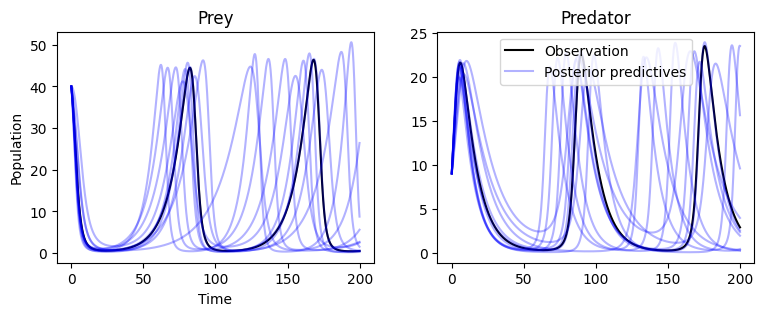

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
_ = ax[0].plot(time_vec, observation[:, 0], c="k")
_ = ax[0].plot(time_vec, posterior_predictives[:, :, 0].T, alpha=0.3, c="b")
_ = ax[0].set_title("Prey")

_ = ax[1].plot(time_vec, observation[:, 1], c="k")
_ = ax[1].plot(time_vec, posterior_predictives[:, :, 1].T, alpha=0.3, c="b")
_ = ax[1].set_title("Predator")

_ = ax[1].legend(["Observation", "Posterior predictives"])
_ = ax[0].set_xlabel("Time")
_ = ax[0].set_ylabel("Population")

As you can see, the posterior predictives (light blue and light orange) look similar to the observation (blue and orange). They do not look exactly the same, but this is expected: we only used the maximum and mean of the two traces as summary statistic.

# Part 4: embedding networks, other methods, and model misspecification

In this section. You can explore making the inference above more accurate. Here are a few ideas:

> 1) Run more simulations. Re-run training and inference. What do you observe?  

> 2) Do not extract summary statistics, but perform inference on the whole time series. Then, [define a neural networks with an embedding network](https://sbi.readthedocs.io/en/latest/how_to_guide/04_embedding_networks.html). Typically, you will need more simulations to train an embedding network.  

> 3) You can also try out other methods. For example, replace `NPE` above with `NLE` or `NRE` (but note that, for this task, we do not expect a major improvement in performance for these methods.  

> 4) Alternatively, you can also check out other simulators. For example, you can check out [this tutorial for a Hodgkin-HJuxley neuroscience simulator](https://sbi.readthedocs.io/en/latest/tutorials/Example_00_HodgkinHuxleyModel.html) or [this tutorial for a drift-diffusion model from psychophysics](https://sbi.readthedocs.io/en/latest/tutorials/Example_01_DecisionMakingModel.html).

# Part 5 (bonus, not discussed): Diagnosing potential issues in the posterior

How do we know that the posterior is correct? The `sbi` toolbox implements a wide range
of methods that diagnose potential issues (more detail in [this how-to guide](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html)). Below, we will perform _simulation-based calibration_ (SBC).

### Simulation-based calibration

Posterior-predictive checks are an ad-hoc heuristic for assessing posterior quality. Simulation-based calibration (SBC) provides a _quantitative_ assessment of posterior quality. It allows you to check, for every parameter, whether the parameter is estimated as (on average) to low, to high, and whether it has too low or two high uncertainty. To run SBC, you first have to generate more simulations based on prior samples:

In [19]:
num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s

prior_samples = prior.sample((num_sbc_samples,))

prior_predictives = parallel_simulate(prior_samples)
prior_predictive_summary_stats = torch.as_tensor(
    np.asarray([summarize_simulation(sim) for sim in prior_predictives]),
    dtype=torch.float32
)

SBC is implemented in `sbi` for your use on any `sbi` posterior. To run it, we only need to call `run_sbc` with appropriate parameters.

In [20]:
from sbi.diagnostics import run_sbc

# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictive_summary_stats,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 200 times (1000,) posterior samples.: 100%|████████████████████| 200/200 [00:01<00:00, 122.30it/s]


Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

> For amortized neural posteriors (like in this tutorial), execution of `sbc` is expected to be fast. For posteriors that conduct inference with MCMC and hence are slow, `run_sbc` exposes the use of multiple internal parallel workers to the user. To use this feature, add `num_workers = 2` to the parameters for use of two workers. See the API documentation for details.


If the posterior approximation is faithful, the `ranks` should be uniformly distributed. We can evaluate this with by plotting a histogram of the resulting ranks:

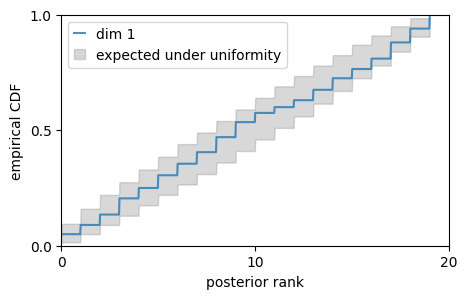

In [21]:
from sbi.analysis.plot import sbc_rank_plot

fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(5, 3),
)

The gray are marks the region which is still sufficiently uniform (meaning that we cannot reject the null hypothesis that the samples are uniform). In this case, all ranks (in red) are within this gray band. This is a good sign, but it is only a necessary---but not a sufficient---condition for the posterior to be correct. To this end, `sbi` implements a wide range of diagnostic methods, which are described [here](https://sbi.readthedocs.io/en/latest/how_to_guide/14_choose_diagnostic_tool.html).